In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
stops = set(stopwords.words("english"))
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
features = [
#     'clean_q1_tokenized',
#     'clean_q2_tokenized',
#     'clean_q1_stem',
#     'clean_q2_stem',
#     'clean_q1_pos_tagged',
#     'clean_q2_pos_tagged',
#     'clean_q1_lemmatized',
#     'clean_q2_lemmatized',
    'clean_q1_lemmatized_stem',
    'clean_q2_lemmatized_stem'
]

In [3]:
def read_data(t, features):
    data = pd.read_csv('../input/{}.csv'.format(t))
    for feature in features:
        data = pd.merge(data, pd.read_pickle('../feature/{}_{}.pkl'.format(t, feature)))
    data.fillna(0.0)
    return data

In [4]:
train = read_data('train', features)#[:100]
test = read_data('test', features)#[:100]

In [5]:
train['clean_q1_lemmatized_stem_str'] = train.clean_q1_lemmatized_stem.map(lambda a: ' '.join(a))
train['clean_q2_lemmatized_stem_str'] = train.clean_q2_lemmatized_stem.map(lambda a: ' '.join(a))

test['clean_q1_lemmatized_stem_str'] = test.clean_q1_lemmatized_stem.map(lambda a: ' '.join(a))
test['clean_q2_lemmatized_stem_str'] = test.clean_q2_lemmatized_stem.map(lambda a: ' '.join(a))

In [6]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))

tfidf_txt = pd.Series(
    train['clean_q1_lemmatized_stem'].tolist() +
    train['clean_q2_lemmatized_stem'].tolist() +
    test['clean_q1_lemmatized_stem'].tolist() +
    test['clean_q2_lemmatized_stem'].tolist()).astype(str)
tfidf.fit_transform(tfidf_txt)

<5500172x92973 sparse matrix of type '<class 'numpy.float64'>'
	with 27579924 stored elements in Compressed Sparse Row format>

In [1]:
tfidf_words = set(tfidf.get_feature_names())

NameError: name 'tfidf' is not defined

In [8]:
from nltk import FreqDist
words = []
for s in tfidf_txt:
    words.extend(s.lower().split())
freq = FreqDist(words)

In [9]:
def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in row['clean_q1_lemmatized_stem']:
        if word not in stops:
            q1words[word] = 1
    for word in row['clean_q2_lemmatized_stem']:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

tfidf_index = {w: i for i, w in enumerate(tfidf.get_feature_names())}
def get_idf(word):
    return tfidf.idf_[tfidf_index[word]]

def word_match_share_idf(row):
    q1words = {}
    q2words = {}
    for word in row['clean_q1_lemmatized_stem']:
        if word not in stops and word in tfidf_words:
            q1words[word] = 1
    for word in row['clean_q2_lemmatized_stem']:
        if word not in stops and word in tfidf_words:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = sum(get_idf(w) for w in q1words.keys() if w in q2words)
    shared_words_in_q2 = sum(get_idf(w) for w in q2words.keys() if w in q1words)
    qq1 = sum(get_idf(w) for w in q1words.keys())
    qq2 = sum(get_idf(w) for w in q2words.keys())
    return (shared_words_in_q1 + shared_words_in_q2) / (qq1 + qq2)


def top_idf_in_share(row):
    q1words = {}
    q2words = {}
    for word in row['clean_q1_lemmatized_stem']:
        if word not in stops:
            q1words[word] = 1
    for word in row['clean_q2_lemmatized_stem']:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    
    return max((get_idf(w) for w in q1words.keys() if w in q2words), default=0)

# def filter_stopwords(s):
#     return [w for w in str(s).lower().split() if w not in stops]

# def filter_stopwords_tok(s):
#     return [w for w in nltk.word_tokenize(str(s).lower()) if w not in stops]

# def n_sim(row):
#     w1 = [w for w in row['q1_tok_words'] if w in model]
#     w2 = [w for w in row['q2_tok_words'] if w in model]
#     if w1 and w2:
#         # s
#         return model.n_similarity(w1, w2)
#     else:
#         return 0


def get_features(df_features):      
#     print('nouns...')
#     df_features['question1_nouns'] = df_features.question1.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
#     df_features['question2_nouns'] = df_features.question2.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
#     df_features['z_noun_match'] = df_features.apply(lambda r: sum([1 for w in r.question1_nouns if w in r.question2_nouns]), axis=1)  #takes long
#     df_features['clean_q2_lemmatized_stem_nouns'] = df_features.clean_q2_lemmatized_stem.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
#     df_features['z_noun_match'] = df_features.apply(lambda r: sum([1 for w in r.clean_q1_lemmatized_stem_nouns if w in r.clean_q2_lemmatized_stem_nouns]), axis=1)  #takes long
#     print('lengths...')
    df_features['clean_lemm_stem_len1'] = df_features.clean_q1_lemmatized_stem_str.map(len)
    df_features['clean_lemm_stem_len2'] = df_features.clean_q2_lemmatized_stem_str.map(len)
    df_features['clean_lemm_stem_word_len1'] = df_features.clean_q1_lemmatized_stem.map(len)
    df_features['clean_lemm_stem_word_len2'] = df_features.clean_q2_lemmatized_stem.map(len)
    print('difflib...')
    df_features['clean_lemm_stem_match_ratio'] = df_features.apply(
        lambda r: diff_ratios(r.clean_q1_lemmatized_stem_str, r.clean_q2_lemmatized_stem_str), axis=1
    )  #takes long
    print('word match...')
    df_features['clean_lemm_stem_word_match'] = df_features.apply(word_match_share, axis=1, raw=True)
    
    print('word match_idf...')
    df_features['clean_lemm_stem_word_match_idf'] = df_features.apply(word_match_share_idf, axis=1, raw=True)
    
#     print('top_idf_in_share')
#     df_features['clean_lemm_stem_top_idf_in_share'] = df_features.apply(top_idf_in_share, axis=1, raw=True)
    
    print('tfidf...')
    q1_tfidf = df_features.clean_q1_lemmatized_stem_str.map(lambda x: tfidf.transform([x]).data)
    q2_tfidf = df_features.clean_q2_lemmatized_stem_str.map(lambda x: tfidf.transform([x]).data)
    
    df_features['clean_lemm_stem_tfidf_sum1'] = q1_tfidf.map(lambda x: np.sum(x))
    df_features['clean_lemm_stem_tfidf_sum2'] = q2_tfidf.map(lambda x: np.sum(x))
    df_features['clean_lemm_stem_tfidf_mean1'] = q1_tfidf.map(lambda x: np.mean(x))
    df_features['clean_lemm_stem_tfidf_mean2'] = q2_tfidf.map(lambda x: np.mean(x))
    df_features['clean_lemm_stem_tfidf_len1'] = q1_tfidf.map(lambda x: len(x))
    df_features['clean_lemm_stem_tfidf_len2'] = q2_tfidf.map(lambda x: len(x))
    
#     print('word2vec...')
#     df_features['q1_tok_words'] = df_features.clean_q1_lemmatized_stem.apply(filter_stopwords_tok)
#     df_features['q2_tok_words'] = df_features.clean_q2_lemmatized_stem.apply(filter_stopwords_tok)
#     df_features['z_n_sim'] = df_features.apply(n_sim, axis=1)

    return df_features.fillna(0.0)


In [10]:
train = get_features(train)
test = get_features(test)

difflib...
word match...
word match_idf...
tfidf...


/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


difflib...
word match...
word match_idf...
tfidf...


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 15.0)

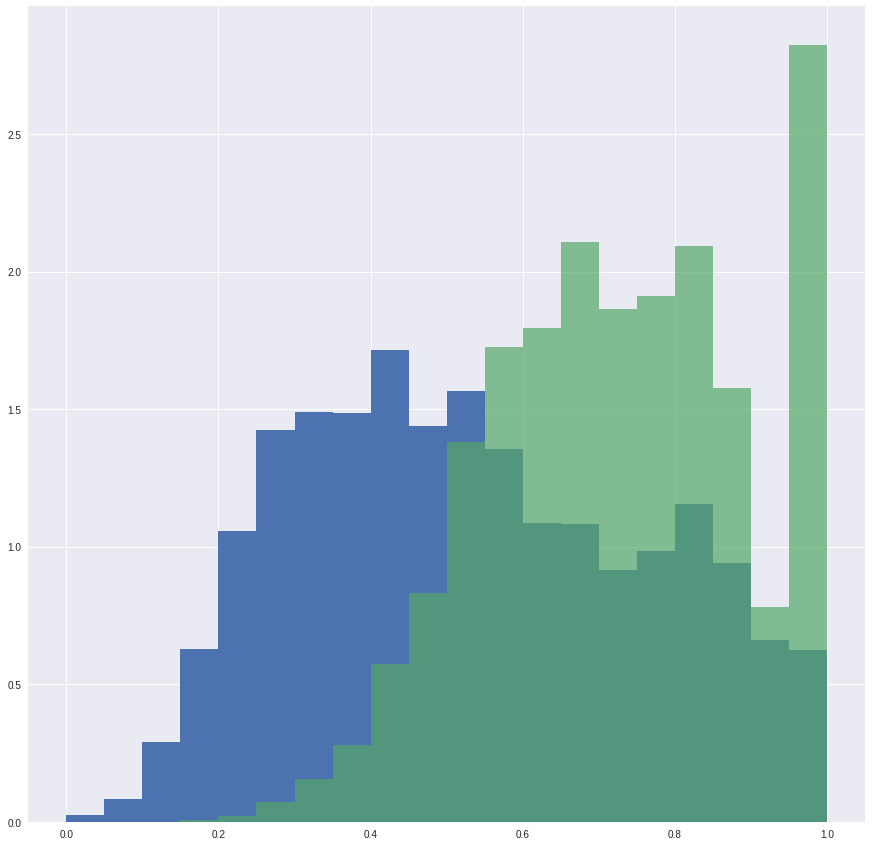

In [12]:
plt.hist(train.clean_lemm_stem_match_ratio[train['is_duplicate'] == 0], bins=20, normed=True, label='0')
plt.hist(train.clean_lemm_stem_match_ratio[train['is_duplicate'] == 1], bins=20, normed=True, label='1', alpha=0.7)
None

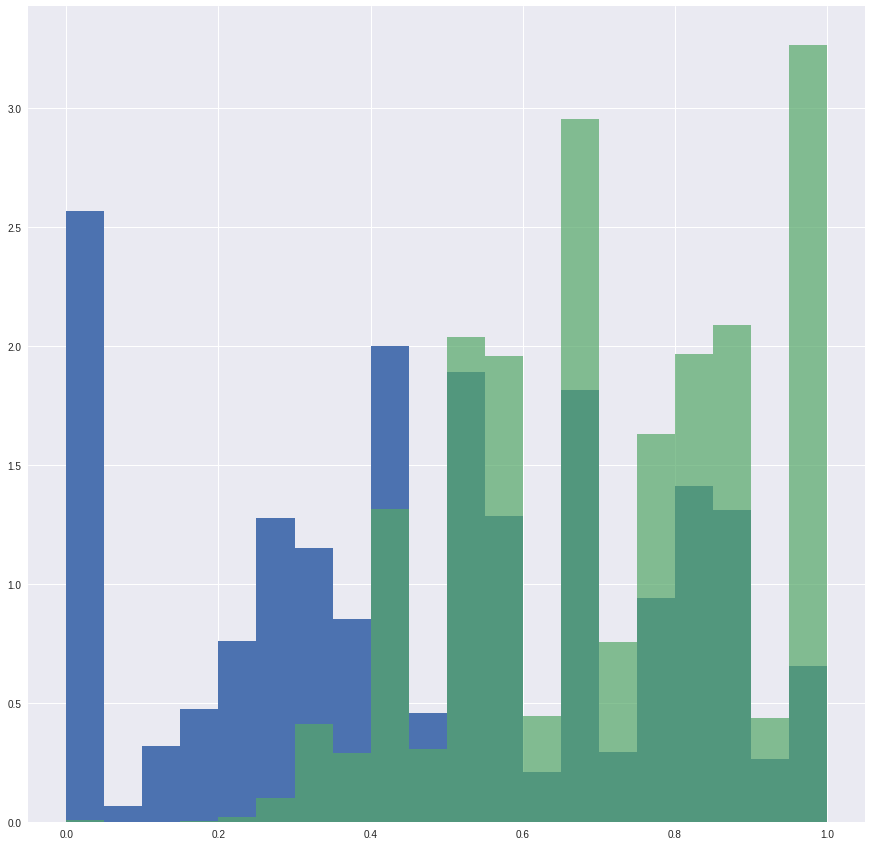

In [13]:
plt.hist(train.clean_lemm_stem_word_match[train['is_duplicate'] == 0], bins=20, normed=True, label='0')
plt.hist(train.clean_lemm_stem_word_match[train['is_duplicate'] == 1], bins=20, normed=True, label='1', alpha=0.7)
None

In [14]:
print(',\n'.join(map(lambda s: "'{}'".format(s), (col for col in train.columns if col.startswith('clean_')))))

'clean_q1_lemmatized_stem',
'clean_q2_lemmatized_stem',
'clean_q1_lemmatized_stem_str',
'clean_q2_lemmatized_stem_str',
'clean_lemm_stem_len1',
'clean_lemm_stem_len2',
'clean_lemm_stem_word_len1',
'clean_lemm_stem_word_len2',
'clean_lemm_stem_match_ratio',
'clean_lemm_stem_word_match',
'clean_lemm_stem_word_match_idf',
'clean_lemm_stem_tfidf_sum1',
'clean_lemm_stem_tfidf_sum2',
'clean_lemm_stem_tfidf_mean1',
'clean_lemm_stem_tfidf_mean2',
'clean_lemm_stem_tfidf_len1',
'clean_lemm_stem_tfidf_len2'


In [15]:
features_to_save = [
    'clean_lemm_stem_len1',
    'clean_lemm_stem_len2',
    'clean_lemm_stem_word_len1',
    'clean_lemm_stem_word_len2',
    'clean_lemm_stem_match_ratio',
    'clean_lemm_stem_word_match',
    'clean_lemm_stem_word_match_idf',
    'clean_lemm_stem_tfidf_sum1',
    'clean_lemm_stem_tfidf_sum2',
    'clean_lemm_stem_tfidf_mean1',
    'clean_lemm_stem_tfidf_mean2',
    'clean_lemm_stem_tfidf_len1',
    'clean_lemm_stem_tfidf_len2'
]

In [16]:
train

,id,qid1,qid2,question1,question2,is_duplicate,clean_q1_lemmatized_stem,clean_q2_lemmatized_stem,clean_q1_lemmatized_stem_str,clean_q2_lemmatized_stem_str,...,clean_lemm_stem_word_len2,clean_lemm_stem_match_ratio,clean_lemm_stem_word_match,clean_lemm_stem_word_match_idf,clean_lemm_stem_tfidf_sum1,clean_lemm_stem_tfidf_sum2,clean_lemm_stem_tfidf_mean1,clean_lemm_stem_tfidf_mean2,clean_lemm_stem_tfidf_len1,clean_lemm_stem_tfidf_len2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]",step step guid invest share market india,step step guid invest share market,...,6,0.918919,0.909091,0.942538,2.257315,2.095621,0.376219,0.419124,6,5
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[stori, kohinoor, koh, noor, diamond]","[would, happen, indian, govern, steal, kohinoo...",stori kohinoor koh noor diamond,would happen indian govern steal kohinoor koh ...,...,10,0.595745,0.533333,0.720984,2.186253,2.712077,0.437251,0.339010,5,8
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dns]",increas speed internet connect use vpn,internet speed increas hack dns,...,5,0.463768,0.545455,0.516600,2.400357,2.185078,0.400060,0.437016,6,5
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mental, lone, solv]","[find, remaind, math, 23, 24, math, divid, 24,...",mental lone solv,find remaind math 23 24 math divid 24 23,...,9,0.214286,0.000000,0.000000,1.723452,2.159769,0.574484,0.431954,3,5
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolv, water, quick, sugar, salt, meth...","[fish, would, surviv, salt, water]",one dissolv water quick sugar salt methan carb...,fish would surviv salt water,...,5,0.238095,0.266667,0.271506,2.960137,1.986765,0.328904,0.496691,9,4
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,"[astrolog, capricorn, sun, cap, moon, cap, ris...","[tripl, capricorn, sun, moon, ascend, capricor...",astrolog capricorn sun cap moon cap rise say,tripl capricorn sun moon ascend capricorn say,...,7,0.719101,0.615385,0.574662,2.428170,2.201280,0.346881,0.366880,7,6
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,"[buy, tiago]","[keep, childern, activ, far, phone, video, game]",buy tiago,keep childern activ far phone video game,...,7,0.204082,0.000000,0.000000,1.329294,2.231520,0.664647,0.371920,2,6
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,"[good, geologist]","[great, geologist]",good geologist,great geologist,...,2,0.758621,0.500000,0.704276,1.266879,1.342705,0.633440,0.671352,2,2
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,"[use, instead]","[use, instead]",use instead,use instead,...,2,1.000000,1.000000,1.000000,1.377027,1.377027,0.688513,0.688513,2,2
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,"[motorola, compani, hack, charter, motorolla, ...","[hack, motorola, dcx3400, free, internet]",motorola compani hack charter motorolla dcx3400,hack motorola dcx3400 free internet,...,5,0.512195,0.545455,0.599266,2.288686,2.075236,0.381448,0.415047,6,5


In [17]:
import util
util.save_feature(train, 'train', features_to_save, 'id')
util.save_feature(test, 'test', features_to_save, 'test_id')